# Walkthrough 7: Coevolving an AI to play Pong

In [1]:
from turtle import Turtle, Screen, Shape
import random
import tkinter as TK
import math
from datetime import datetime
import numpy as np
import time

random.seed(datetime.now()) # Set a random seed from the clock
#random.seed(98)

In [2]:
class UndrawnTurtle(): # We use this to keep track of the turtles without having to draw them
    def __init__(self):
        self.x, self.y, self.x_prev, self.y_prev, self.angle = 0.0, 0.0, 0.0, 0.0, 0.0

    def position(self):
        return self.x, self.y

    def xcor(self):
        return self.x

    def ycor(self):
        return self.y

    def xcor_prev(self):
        return self.x_prev

    def ycor_prev(self):
        self.y_prev = self.y
        return self.y_prev
    
    def setx(self, xcor):
        self.x_prev = self.x
        self.x = xcor

    def sety(self, ycor):
        self.y = ycor
    
    def forward(self, distance):
        angle_radians = math.radians(self.angle)
        self.x_prev = self.x
        self.y_prev = self.y
        self.x += math.cos(angle_radians) * distance
        self.y += math.sin(angle_radians) * distance

    def backward(self, distance):
        self.forward(-distance)

    def right(self, angle):
        self.angle -= angle

    def left(self, angle):
        self.angle += angle

    def setpos(self, x, y = None):
        # Can be passed either a tuple or two numbers
        self.x_prev = self.x
        self.y_prev = self.y
        if y == None:
            self.x = x[0]
            self.y = y[1]
        else:
            self.x = x
            self.y = y

In [3]:
class MLP(object):
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        self.fitness = 0
        self.numInput = numInput
        self.numHidden1 = numHidden1
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput) 
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1) 
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.b_i_h1 = [0] * numHidden1
        self.b_i_h2 = [0] * numHidden2
        self.b_i_output = [0] * numOutput

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
        
    def feed_forward(self, inputs):

        h1 = np.dot(self.w_i_h1, inputs)             # feed input to hidden layer 1     
        h1 = [h + b for h, b in zip(h1, self.b_i_h1)]
        
        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1
               
        h2 = np.dot(self.w_h1_h2, h1)                # feed layer 1 to hidden layer 2
        h2 = [h + b for h, b in zip(h2, self.b_i_h2)]
        h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)             # feed to output layer
        output = [o + b for o, b in zip(output, self.b_i_output)]
        #output = [math.tanh(x) for x in output]      # Activate output layer
        output = self.softmax(output)
        return output
    
    # Weights get set as:
    # Weights to layer h1, h2, o
    # Biases to layer h1, h2, o
    def set_weights_linear(self, Wgenome):
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * self.numHidden1
        numWeights_H2_O = self.numOutput * self.numHidden2

        # Weights (multi-dimensional arrays)
        
        first_slice_end = numWeights_I_H1
        
        self.w_i_h1 = np.array(Wgenome[:first_slice_end])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))
        
        second_slice_end = first_slice_end + numWeights_H1_H2
        
        self.w_h1_h2 = np.array(Wgenome[first_slice_end:second_slice_end])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        third_slice_end = second_slice_end + numWeights_H2_O
        
        self.w_h2_o = np.array(Wgenome[second_slice_end:third_slice_end])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

        # Biases (flat arrays for each layer)
        
        fourth_slice_end = third_slice_end + self.numHidden1
        
        self.b_i_h1 = np.array(Wgenome[third_slice_end:fourth_slice_end])
        
        fith_slice_end = fourth_slice_end + self.numHidden2
        
        self.b_i_h2 = np.array(Wgenome[fourth_slice_end:fith_slice_end])
               
        self.b_i_output = np.array(Wgenome[fith_slice_end:])

# This is the class containing all the game display code

In [4]:
class DisplayGame:
        
    def __init__(self, window_height, window_width, bat_w_half, bat_h_half):
        # SCREEN
        self.screen = Screen()
        self.screen.setup(window_height, window_width)   # width, height
        self.screen.tracer(0)         # We will handle displaying of frames ourselves

        # PLAY ARENA
        self.play_top    = window_height / 2 - 80    # top of screen minus 100 units
        self.play_bottom = -window_height / 2 + 80   # 100 from bottom
        self.play_left   = -window_width / 2 + 50    # 50 from left
        self.play_right  = window_width / 2 - 50     # 50 from right

        self.area = Turtle()
        self.area.hideturtle()

        # batS
        self.L = Turtle()
        self.R = Turtle()
        self.L.penup()
        self.R.penup()

        # bats shape
        self.bat_shape = Shape("compound")
        self.bat_points = ((-bat_h_half, -bat_w_half),
                         (-bat_h_half, bat_w_half),
                         (bat_h_half, bat_w_half),
                         (bat_h_half, -bat_w_half))
        self.bat_shape.addcomponent(self.bat_points, "blue")
        self.screen.register_shape("bat", self.bat_shape)
        self.L.shape("bat")
        self.R.shape("bat")

        # SCORE
        self.score_turtle = Turtle()
        self.score_turtle.penup()
        self.score_turtle.hideturtle()

        # BALL
        self.ball = Turtle()
        self.ball.penup()
        self.ball.shape("circle")        # Use the built-in shape "circle"
        self.ball.color("blue")
        self.ball.shapesize( 0.5, 0.5)   # Stretch it to half default size

        self.reset()

    def reset(self):
        
        self.area.penup()
        self.area.goto(self.play_right, self.play_top)
        self.area.pendown()
        self.area.goto(self.play_left, self.play_top)
        self.area.goto(self.play_left, self.play_bottom)
        self.area.goto(self.play_right, self.play_bottom)
        self.area.goto(self.play_right, self.play_top)
        
         # Move bats into position
        self.L.setx(self.play_left + 10)
        self.R.setx(self.play_right - 10)
        
        self.update_score(0,0)
        self.screen.update()
        
    def update_ball_position(self, ball_x_pos, ball_y_pos):
        self.ball.setpos(ball_x_pos, ball_y_pos)
        
    def update_L_bat_position(self, L_x_pos, L_y_pos):
        self.L.setpos(L_x_pos, L_y_pos)

    def update_R_bat_position(self, R_x_pos, R_y_pos):
        self.R.setpos(R_x_pos, R_y_pos)

    def update_score(self, L_score, R_score):
        self.score_turtle.clear()
        self.score_turtle.goto(-self.screen.window_width()/4, self.screen.window_height()/2 - 40)
        self.score_turtle.write(L_score, align="center", font=("Arial", 32, "bold"))
        self.score_turtle.goto(self.screen.window_width()/4, self.screen.window_height()/2 - 40)
        self.score_turtle.write(R_score, align="center", font=("Arial", 32, "bold"))

This is the class containing all the game code

In [5]:
class Pong:
        
    def __init__(self):

        self.window_height = 600
        self.window_width = 550
        
        # PLAY ARENA
        self.play_top    = self.window_height / 2 - 80    # top of screen minus 100 units
        self.play_bottom = -self.window_height / 2 + 80   # 100 from bottom
        self.play_left   = -self.window_width / 2 + 50    # 50 from left
        self.play_right  = self.window_width / 2 - 50     # 50 from right

        self.area = UndrawnTurtle()

        # batS
        self.L = UndrawnTurtle()
        self.R = UndrawnTurtle()

        # bat size
        self.bat_w_half = 5  
        self.bat_h_half = 35

        # BALL
        self.ball = UndrawnTurtle()
        self.ball_radius = 10 * 0.5

        self.ball_move_horiz = 0          # current x speed    
        self.ball_move_vert  = 0          # current y speed
        self.slow_ball_speed = 3
        self.fast_ball_speed = self.slow_ball_speed * 2

        self.ball_speed = self.slow_ball_speed
        self.maxBounceAngleRadians = 1.04 # ~60 degrees

        self.reset()

    def reset(self):
              
         # Move bats into position
        self.L.setx(self.play_left + 10)
        self.R.setx(self.play_right - 10)

        self.bat_L_move_direction = 0   # L bat movement direction in next frame
        self.bat_R_move_direction = 0   # R bat movement direction in next frame
        
        self.bat_move_vert = 4
        
        self.score_L = 0
        self.score_R = 0
        
        if random.random() > 0.5:
            self.direction_horiz = 1
        else:
            self.direction_horiz = -1
            
        self.start_ball_direction = self.direction_horiz
       
        self.reset_ball()
        
    def bat_is_allowed_to_move_here(self, new_y_pos):
        if (self.play_bottom > new_y_pos - self.bat_h_half) : 
            return False
        if (new_y_pos + self.bat_h_half > self.play_top) :   
            return False
        return True

    def update_bat_positions(self):
        L_new_y_pos = self.L.ycor() + (self.bat_L_move_direction * self.bat_move_vert)
        R_new_y_pos = self.R.ycor() + (self.bat_R_move_direction * self.bat_move_vert)
        if self.bat_is_allowed_to_move_here(L_new_y_pos):
            self.L.sety( L_new_y_pos )
        if self.bat_is_allowed_to_move_here(R_new_y_pos):
            self.R.sety( R_new_y_pos )

    def L_up(self):
        self.bat_L_move_direction = 1

    def L_down(self):
        self.bat_L_move_direction = -1

    def L_off(self):
        self.bat_L_move_direction = 0

    def R_up(self):
        self.bat_R_move_direction = 1

    def R_down(self):
        self.bat_R_move_direction = -1

    def R_off(self):
        self.bat_R_move_direction = 0

    def check_if_someone_scores(self):
        if (self.ball.xcor() + self.ball_radius) >= self.play_right:
            self.score_L += 1
            self.reset_ball()
            return True
        elif self.play_left >= (self.ball.xcor() - self.ball_radius):  
            self.score_R += 1
            self.reset_ball()
            return True
        else:
            return False

    def ball_collides_with_bat(self, bat):
        self.ball_speed = self.fast_ball_speed              # Set it to full speed after the first hit
        x_distance = abs(bat.xcor() - self.ball.xcor())
        y_distance = abs(bat.ycor() - self.ball.ycor())
        overlap_horizontally = (self.ball_radius + self.bat_w_half >= x_distance) 
        overlap_vertically   = (self.ball_radius + self.bat_h_half >= y_distance) 
        return overlap_horizontally and overlap_vertically         
  
    def update_ball_position(self):
        if (self.ball.ycor() + self.ball_radius > self.play_top) and (self.ball_move_vert > 0): 
            self.ball_move_vert *= -1
        elif (self.play_bottom > self.ball.ycor() - self.ball_radius) and (self.ball_move_vert < 0):  
            self.ball_move_vert *= -1
            
        if self.ball_collides_with_bat(self.L) and self.ball_move_horiz < 0:
            relativeIntersectY = self.ball.ycor() - self.L.ycor()
            normalizedRelativeIntersectionY = (relativeIntersectY / self.bat_h_half)
            bounceAngle = normalizedRelativeIntersectionY * self.maxBounceAngleRadians
            self.ball_move_vert = self.ball_speed * math.sin(bounceAngle)
            self.ball_move_horiz = self.ball_speed * math.cos(bounceAngle)
        elif self.ball_collides_with_bat(self.R) and self.ball_move_horiz > 0:
            relativeIntersectY = self.ball.ycor() - self.R.ycor()
            normalizedRelativeIntersectionY = (relativeIntersectY / self.bat_h_half)
            bounceAngle = normalizedRelativeIntersectionY * self.maxBounceAngleRadians
            self.ball_move_vert = self.ball_speed * math.sin(bounceAngle)
            self.ball_move_horiz = self.ball_speed * -math.cos(bounceAngle)

        self.ball.setx(self.ball.xcor() + self.ball_move_horiz)
        self.ball.sety(self.ball.ycor() + self.ball_move_vert)

    def reset_ball(self):     
        self.ball_speed = self.slow_ball_speed
        
        if self.start_ball_direction == 1:
            self.direction_horiz = -1
            self.start_ball_direction = -1
            self.ball.setpos((self.window_width / 2) - 100, (self.window_height / 2) - 50)
        else:
            self.direction_horiz = 1
            self.start_ball_direction = 1
            self.ball.setpos((-self.window_width / 2) + 100, (self.window_height / 2) - 50)          

        bounceAngle = random.uniform(0.2, self.maxBounceAngleRadians)
        
        self.ball_move_vert = self.ball_speed * math.sin(bounceAngle)
        self.ball_move_horiz = self.ball_speed * (self.direction_horiz*math.cos(bounceAngle))
        
#    def L_move_AI(self): # Simple AI for moving the left bat
#        if self.ball.xcor() < 60:
#            if self.L.ycor() < (self.ball.ycor() -40 ):
#                self.bat_L_move_direction = 1
#            elif self.L.ycor() > (self.ball.ycor() + 40 ):
#                self.bat_L_move_direction = -1
#            else:
#                self.bat_L_move_direction = 0

    def L_move_AI(self, AIbrain): 
        observed_y_velocity = (self.ball.ycor()-self.ball.ycor_prev())
        observed_x_velocity = (self.ball.xcor()-self.ball.xcor_prev())
        output = AIbrain.feed_forward( [self.ball.ycor(), self.ball.xcor(), observed_y_velocity, observed_x_velocity, self.L.ycor() ] )
        decision = np.argmax(output, axis=0)
        if decision == 1:
            self.bat_L_move_direction = 1
        elif decision == 2:
            self.bat_L_move_direction = -1
        else:
            self.bat_L_move_direction = 0
        '''
        if self.ball.xcor() < 60:
            if self.L.ycor() < (self.ball.ycor() -40 ):
                self.bat_L_move_direction = 1
            elif self.L.ycor() > (self.ball.ycor() + 40 ):
                self.bat_L_move_direction = -1
            else:
                self.bat_L_move_direction = 0
        '''

    def R_move_AI(self, AIbrain):
        observed_y_velocity = (self.ball.ycor()-self.ball.ycor_prev())
        observed_x_velocity = (self.ball.xcor()-self.ball.xcor_prev())
        output = AIbrain.feed_forward( [self.ball.ycor(), self.ball.xcor(), observed_y_velocity, observed_x_velocity, self.R.ycor() ] )
        decision = np.argmax(output, axis=0)
        if decision == 1:
            self.bat_R_move_direction = 1
        elif decision == 2:
            self.bat_R_move_direction = -1
        else:
            self.bat_R_move_direction = 0


In [6]:
def playGame(PongGame, AIbrain1, AIbrain2, headless=False, maxTimesteps=5000): # Pass your evolved AI in to here

    PongGame.reset()
    running = True
    timesteps = 0
    if not headless:
        pongDisplay = DisplayGame(pongGame.window_height, pongGame.window_width, pongGame.bat_w_half, pongGame.bat_h_half)
        
    for timesteps in range( maxTimesteps ):
        pongGame.L_move_AI(AIbrain1)
        pongGame.R_move_AI(AIbrain2)
        pongGame.update_bat_positions()
        pongGame.update_ball_position()          
        score_changed = pongGame.check_if_someone_scores()

        # Let your algorithm decide on its move here (the options are L.up, L.down, or L.off)
        if not headless:
            time.sleep(0.005)
            pongDisplay.update_ball_position( pongGame.ball.xcor(), pongGame.ball.ycor() )
            pongDisplay.update_L_bat_position( pongGame.L.xcor(), pongGame.L.ycor() )
            pongDisplay.update_R_bat_position( pongGame.R.xcor(), pongGame.R.ycor() )
            if score_changed: pongDisplay.update_score( pongGame.score_L, pongGame.score_R)
            pongDisplay.screen.update()

    #print("Game Over! Scores - L: ", pongGame.score_L, " R: ", pongGame.score_R)
    if not headless: TK.mainloop() # terminate window
    # Returns fitness of right bat and bitness of left bat
    return( (pongGame.score_L - pongGame.score_R), (pongGame.score_R - pongGame.score_L) )

# The coevolutionary algorithm

In [7]:
from deap import base
from deap import creator
from deap import tools

In [8]:
NGEN, MUT_PROB = 300, 0.5 # Remember MUT_PROB is the probability of an individual being mutated at all

In [9]:
NUM_OPPONENTS = 2

In [10]:
num_input_nodes = 5
num_hidden_nodes_1 = 4
num_hidden_nodes_2 = 4
num_output_nodes = 3

NUM_WEIGHTS = (num_input_nodes * num_hidden_nodes_1) + (num_hidden_nodes_1 * num_hidden_nodes_2) + (num_hidden_nodes_2 * num_output_nodes)
NUM_BIASES = num_hidden_nodes_1 + num_hidden_nodes_2 + num_output_nodes

IND_SIZE = NUM_WEIGHTS + NUM_BIASES

In [11]:
player_1_network = MLP(num_input_nodes, num_hidden_nodes_1, num_hidden_nodes_2, num_output_nodes)
player_2_network = MLP(num_input_nodes, num_hidden_nodes_1, num_hidden_nodes_2, num_output_nodes)

In [12]:
pongGame = Pong()

In [13]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1., 1.)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

The evaluate function I've written is slightly different from what you've seen previously. It calculates the fitnesses for all individuals in a population, rather than just for an individual. I did this because there is more code and I wanted to keep it in one place. You don't have to do it this way.

For efficiency this evaluation function pairs up individuals from both populations and gets the fitness of each population from the same sets of games. This avoids information wasteage in the above functions, at the expense of some diversity in evaluation.

In [14]:
def evaluate(pop_L, pop_R, p_L_network, p_R_network, maxTimesteps):
    fitnesses_L = [0.0] * len(pop_L)
    fitnesses_R = [0.0] * len(pop_R)

    playOrderL = list(range(len(popL)))
    playOrderR = list(range(len(popR)))

    # How many times does each individual play to get evaluated?
    for i in list(range(NUM_OPPONENTS)):
        # Randomize the order of pop L to play against corresponding individuals in pop R
        random.shuffle( playOrderL )

        for i_L, i_R in zip( playOrderL, playOrderR ):
            p_L_network.set_weights_linear( popL[i_L] )
            p_R_network.set_weights_linear( popR[i_R] )
            fitness_L, fitness_R = playGame(pongGame, p_L_network, p_R_network, headless=True, maxTimesteps=maxTimesteps)
            fitnesses_L[i_L] += fitness_L
            fitnesses_R[i_R] += fitness_R
        
    fitnesses_L[i] = fitnesses_L[i] / NUM_OPPONENTS
    fitnesses_R[i] = fitnesses_R[i] / NUM_OPPONENTS

    # Careful here, we are returning the lists of fitnesses of both pops
    return fitnesses_L, fitnesses_R

In [15]:
#toolbox.register("evaluate", evaluate)
#toolbox.register("evaluateL", evaluatePopL)
#toolbox.register("evaluateR", evaluatePopR)
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.2, indpb=0.1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [16]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [17]:
popL = toolbox.population(n=100)
popR = toolbox.population(n=100)

In [18]:
fitnessesL, fitnessesR = toolbox.evaluate(popL, popR, player_1_network, player_2_network, maxTimesteps=2000)
for ind, fit in zip(popL, fitnessesL):
    ind.fitness.values = fit,

for ind, fit in zip(popR, fitnessesR):
    ind.fitness.values = fit,

In [19]:
logbookL = tools.Logbook()
recordL = stats.compile(popL)
logbookL.record(gen=0, **recordL)

logbookR = tools.Logbook()
recordR = stats.compile(popR)
logbookR.record(gen=0, **recordR)

In [20]:
for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    selectedL = toolbox.select(popL, len(popL))
    offspringL = list(map(toolbox.clone, selectedL))
    for mutantL in offspringL:
        if random.random() < MUT_PROB:
            toolbox.mutate(mutantL)
    popL[:] = offspringL
        
    selectedR = toolbox.select(popR, len(popR))
    offspringR = list(map(toolbox.clone, selectedR))
    for mutantR in offspringR:
        if random.random() < MUT_PROB:
            toolbox.mutate(mutantR)
    popR[:] = offspringR
          
    fitnessesL, fitnessesR = toolbox.evaluate(popL, popR, player_1_network, player_2_network, maxTimesteps=2500)
    for ind, fit in zip(popL, fitnessesL):
        ind.fitness.values = fit,

    for ind, fit in zip(popR, fitnessesR):
        ind.fitness.values = fit,
    
    recordL = stats.compile(popL)
    logbookL.record(gen=g, **recordL)

    recordR = stats.compile(popR)
    logbookR.record(gen=g, **recordR)

-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

genR = logbookR.select("gen")
_minR = logbookR.select("min")
_maxR = logbookR.select("max")
avgsR = logbookR.select("avg")
stdsR = logbookR.select("std")

genL = logbookL.select("gen")
_minL = logbookL.select("min")
_maxL = logbookL.select("max")
avgsL = logbookL.select("avg")
stdsL = logbookL.select("std")

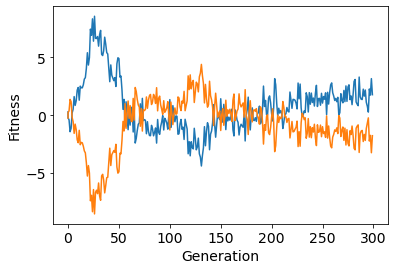

In [22]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(genR, avgsR)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(genL, avgsL)

# Save the best individual and watch them play

In [24]:
bestIndR = tools.selBest(popR, 1)[0]
bestIndL = tools.selBest(popL, 1)[0]

In [25]:
player_2_network.set_weights_linear(bestIndR)
player_1_network.set_weights_linear(bestIndL)

In [27]:
fitness = playGame(pongGame, player_1_network, player_2_network, headless=False, maxTimesteps=2000)

In [ ]:
fitness

In [ ]:
logbookR.select("max")

In [26]:
import pickle

cp = dict(populationR=popR, populationL=popL, generation=g,
          logbookR=logbookR, logbookL=logbookL, rndstate=random.getstate())

with open("checkpoint.pkl", "wb") as cp_file:
    pickle.dump(cp, cp_file)

In [ ]:
with open("checkpoint.pkl", "rb") as cp_file:
    cp = pickle.load(cp_file)
    
popR = cp["populationR"]
popL = cp["populationL"]
start_gen = cp["generation"]
#####halloffame = cp["halloffame"]
logbookR = cp["logbookR"]
logbookL = cp["logbookL"]
random.setstate(cp["rndstate"])